In [268]:
import io
from collections import Counter

import numpy as np
import scipy.io
import sklearn.model_selection
import sklearn.tree
from numpy import genfromtxt
from scipy import stats
from sklearn.base import BaseEstimator, ClassifierMixin
import statistics
import matplotlib.pyplot as plt

import pandas as pd
import pydot
import gprof2dot

### 3.1

In [177]:
np.random.seed(59)

eps = 1e-5  # a small number


class DecisionTree:
    def __init__(self, max_depth=3, feature_labels=None, my_feats=None):
        self.max_depth = max_depth
        self.features = feature_labels
        self.my_feats = None
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes
        self.my_split = None 
        self.my_thresh = None

    @staticmethod
    def information_gain(X, y, thresh):
        # TODO implement information gain function
        # H_after - H_before where H_after is a weighted average 
        # of the GINI IMPURITY of the left and right nodes
        before_1 = np.count_nonzero(y)/len(y)
        before_0 = 1 - before_1
        before_H = before_1*(1-before_1) + before_0*(1-before_0)
        
        # Splitting with threshold
        after_l_idx = [i for i in np.arange(0, len(X)) if X[i] < thresh]
        after_r_idx = [i for i in np.arange(0, len(X)) if X[i] >= thresh]
        # Finding left and right data sets
        l_y = y[after_l_idx]
        l_X = X[after_l_idx]
        r_y = y[after_r_idx]
        r_X = X[after_r_idx]
        
        # Calculating impurities, setting to 0 if there is nothing in the branch
        imp_r = 0
        imp_l = 0
        
        if len(r_y) != 0:
            p_1_r = np.count_nonzero(r_y)/len(r_y)
            p_0_r = 1 - p_1_r
            imp_r = p_1_r*(1-p_1_r) + p_0_r*(1-p_0_r)
        if len(l_y) != 0:
            p_1_l = np.count_nonzero(l_y)/len(l_y)
            p_0_l = 1 - p_1_l
            imp_l = p_1_l*(1-p_1_l) + p_0_l*(1-p_0_l)
        
        after_H = (len(l_y)*imp_l + len(r_y)*imp_r)/(len(y))
        
        return before_H - after_H

    @staticmethod
    def gini_impurity(X, y, thresh):
        # TODO implement gini_impurity function
        # Done! But I never used it :/
        p_1 = sum(y)/len(y)
        p_0 = (1 - p_1)/len(y)
        gini = p_1*(1-p_1) + p_0*(1-p_0)
        return gini

    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1

    def fit(self, X, y, m=0):
        if m != 0:
            rand_feats = np.random.choice(X.shape[1], m)
            X_ = X[:, rand_feats]
            self.my_feats = self.features[rand_feats]
        else:
            X_ = X
        if self.max_depth > 0:
            # compute entropy gain for all single-dimension splits,
            # thresholding with a linear interpolation of 10 values
            gains = []
            # The following logic prevents thresholding on exactly the minimum
            # or maximum values, which may not lead to any meaningful node
            # splits.
            thresh = np.array([
                np.linspace(np.min(X_[:, i]) + eps, np.max(X_[:, i]) - eps, num=10)
                for i in range(X_.shape[1])
            ])
            for i in range(X_.shape[1]):
                gains.append([self.information_gain(X_[:, i], y, t) for t in thresh[i, :]])

            gains = np.nan_to_num(np.array(gains))
            self.split_idx, thresh_idx = np.unravel_index(np.argmax(gains), gains.shape)
            self.thresh = thresh[self.split_idx, thresh_idx]
            X0, y0, X1, y1 = self.split(X_, y, idx=self.split_idx, thresh=self.thresh)
            
            if X0.size > 0 and X1.size > 0:
                self.left = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.left.fit(X0, y0, m)
                self.right = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.right.fit(X1, y1, m)
            else:
                self.max_depth = 0
                self.data, self.labels = X_, y
                self.pred = stats.mode(y).mode[0]
        else:
            self.data, self.labels = X_, y
            self.pred = stats.mode(y).mode[0]
        return self

    def predict(self, X):
        if self.max_depth == 0:
            return self.pred * np.ones(X.shape[0])
        else:
            X0, idx0, X1, idx1 = self.split_test(X, idx=self.split_idx, thresh=self.thresh)
            yhat = np.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0)
            yhat[idx1] = self.right.predict(X1)
            return yhat

### 3.2

In [178]:
np.random.seed(84)
class BaggedTrees:
    def __init__(self, max_depth=3, n=200):
        self.n = n
        self.trees = [DecisionTree(max_depth=max_depth) for i in np.arange(self.n)]
        self.max_depth = max_depth
        
    def fit(self, X, y, feature_labels):
        # TODO implement function
        # I hope this works?
        for i in self.trees:
            i.features = feature_labels
            boot_idx = np.random.choice(len(y), len(y))
            boot_y = y[boot_idx]
            boot_X = X[boot_idx, :]
            i.fit(boot_X, boot_y)
        return self

    def predict(self, X):
        # TODO implement function
        # Hope this is right? 
        # For BaggedTrees, I will use the mode of all trees as the prediction.
        pred_mat = []
        bag_preds = []
        for tree in self.trees:
            this = tree.predict(X)
            pred_mat.append(this)
        pred_mat = np.array(pred_mat)
        for s in np.arange(len(X)):
            all_preds = pred_mat[:, s]
            if np.count_nonzero(all_preds) != .5*len(all_preds):
                mode = statistics.mode(all_preds)
            else:
                mode = 0
            bag_preds.append(mode)
        return bag_preds

In [179]:
np.random.seed(17)
class RandomForest(BaggedTrees):
    def __init__(self, max_depth=3, n=200, m=1):
        BaggedTrees.__init__(self)
        self.n = n
        self.m = 1
        
    def fit(self, X, y, feature_labels):
        self.m = int(np.rint(np.sqrt(X.shape[1])))
        for tree in self.trees:
            tree.features = feature_labels
            boot_idx = np.random.choice(len(y), len(y))
            boot_y = y[boot_idx]
            boot_X = X[boot_idx, :]
            tree.features = feature_labels
            tree.fit(boot_X, boot_y, self.m)
        return self
    def predict(self, X):
        return BaggedTrees.predict(self, X)

### Data Processing and Cleaning, Debugging

In [180]:
titanic_data = pd.read_csv('titanic_training.csv')
titanic_labels = titanic_data.iloc[:, 0].values
titanic_X = titanic_data.drop('survived', axis=1)
titanic_test = pd.read_csv('titanic_testing_data.csv')

def titanic_process(data):
    # dropping unhelpful features
    data = data.drop(['ticket', 'cabin'], axis=1)
    # filling NaN values with mode
    for col in data.columns:
        mode = data[col].value_counts().index[0]
        data[col] = data[col].fillna(mode)
    
    # one-hot encoding the categorical variables
    sex_onehot = pd.get_dummies(data['sex'],prefix='sex')
    embark_onehot = pd.get_dummies(data['embarked'], prefix='embarked')
    data = pd.concat([data,sex_onehot],axis=1).drop(['sex'],axis=1)
    data = pd.concat([data,embark_onehot],axis=1).drop(['embarked'],axis=1)
    
    return data

# making matrices of the feature values
titanic_X = titanic_process(titanic_X)
titanic_test = titanic_process(titanic_test)

In [181]:
# Trying to see if my data cleaning worked
dt = DecisionTree(max_depth=5, feature_labels=titanic_X.columns)
dt.fit(titanic_X.values, titanic_labels)
dt_preds = dt.predict(titanic_test.values)

In [182]:
# Seems like the RandomForest works on titanic data.
t_rf = RandomForest(max_depth=5, n=200)
t_rf.fit(titanic_X.values, titanic_labels, titanic_X.columns)
t_rf_preds = t_rf.predict(titanic_test.values)

In [183]:
# most of the predicted values are the same
np.sum(dt_preds == t_rf_preds)

215

In [277]:
# Loading spam data, with the help of the starter code
features = [
            "pain", "private", "bank", "money", "drug", "spam", "prescription", "creative",
            "height", "featured", "differ", "width", "other", "energy", "business", "message",
            "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out",
            "semicolon", "dollar", "sharp", "exclamation", "parenthesis", "square_bracket",
            "ampersand"
        ]
assert len(features) == 32

data = scipy.io.loadmat('spam_data.mat')
spam_train = data['training_data']
spam_labels = np.squeeze(data['training_labels'])
spam_test = data['test_data']

# Verifying that there are no missing values in the spam data
np.sum(np.isnan(spam_train))
np.sum(np.isnan(spam_test))
np.sum(np.isnan(spam_labels))

0

In [160]:
# Testing to see if this data will work with my decision trees...
spam_dt = DecisionTree(max_depth=5, feature_labels=features)
spam_dt.fit(spam_train, spam_labels)
spam_dt_preds = spam_dt.predict(spam_test)
# This also works! 

# What about RandomForest?

spam_rf_test = RandomForest(max_depth=5, n=200)
spam_rf_test.fit(spam_train, spam_labels, np.array(features))
rf_preds = spam_rf_test.predict(spam_test)

In [161]:
# Seems like most of these are
np.sum(spam_dt_preds == rf_preds)/len(spam_dt_preds)

0.7129929998292641

### 3.4

In [260]:
# Splitting train and validation data for titanic dataset
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    titanic_X.values, titanic_labels, test_size=0.20, random_state=42)

In [163]:
# Training and validation accuracies for Titanic dataset
rec_dt_t = DecisionTree(max_depth=5, feature_labels=titanic_X.columns)
rec_dt_t.fit(X_train, y_train)
rec_dt_t_tr = np.sum(rec_dt_t.predict(X_train) == y_train)/len(y_train)
rec_dt_t_acc = np.sum(rec_dt_t.predict(X_test) == y_test)/len(y_test)
print("The training accuracy of the decision tree on the titanic dataset is " + str(rec_dt_t_tr))
print("The validation accuracy of the decision tree on the titanic dataset is " + str(rec_dt_t_acc))

rec_rf_t = RandomForest(max_depth=5, n=200)
rec_rf_t.fit(X_train, y_train, titanic_X.columns)
rec_rf_t_tr = np.sum(rec_rf_t.predict(X_train) == y_train)/len(y_train)
rec_rf_t_acc = np.sum(rec_rf_t.predict(X_test) == y_test)/len(y_test)
print("The training accuracy of the random forest on the titanic dataset is " + str(rec_rf_t_tr))
print("The validation accuracy of the random forest on the titanic dataset is " + str(rec_rf_t_acc))

The training accuracy of the decision tree on the titanic dataset is 0.8275
The validation accuracy of the decision tree on the titanic dataset is 0.835
The training accuracy of the random forest on the titanic dataset is 0.67125
The validation accuracy of the random forest on the titanic dataset is 0.675


In [195]:
# Splitting train and validation data for spam dataset
X_trains, X_tests, y_trains, y_tests = sklearn.model_selection.train_test_split(
    spam_train, spam_labels, test_size=0.20, random_state=50)

In [193]:
# Training and validation accuracies for Spam dataset
rec_dt_s = DecisionTree(max_depth=5, feature_labels=features)
rec_dt_s.fit(X_trains, y_trains)
rec_dt_s_tr = np.sum(rec_dt_s.predict(X_trains) == y_trains)/len(y_trains)
rec_dt_s_acc = np.sum(rec_dt_s.predict(X_tests) == y_tests)/len(y_tests)
print("The training accuracy of the decision tree on the spam dataset is " + str(rec_dt_s_tr))
print("The validation accuracy of the decision tree on the spam dataset is " + str(rec_dt_s_acc))

rec_rf_s = RandomForest(max_depth=5, n=200)
rec_rf_s.fit(X_trains, y_trains, np.array(features))
rec_rf_s_tr = np.sum(rec_rf_s.predict(X_trains) == y_trains)/len(y_trains)
rec_rf_s_acc = np.sum(rec_rf_s.predict(X_tests) == y_tests)/len(y_tests)
print("The training accuracy of the random forest on the spam dataset is " + str(rec_rf_s_tr))
print("The validation accuracy of the random forest on the spam dataset is " + str(rec_rf_s_acc))

The training accuracy of the decision tree on the spam dataset is 0.8095238095238095
The validation accuracy of the decision tree on the spam dataset is 0.8222222222222222
The training accuracy of the random forest on the spam dataset is 0.708726130045927
The validation accuracy of the random forest on the spam dataset is 0.714975845410628


In [194]:
kag_dt_s = DecisionTree(max_depth=5, feature_labels=features)
kag_dt_s.fit(spam_train, spam_labels)
kag_dt_s_pred = kag_dt_s.predict(spam_test).astype(int)
kag_spam = pd.DataFrame(kag_dt_s_pred, np.arange(1, len(kag_dt_s_pred) + 1))
kag_spam.reset_index(level=0, inplace=True)
kag_spam.to_csv("spam_pred", header=["Id", "Category"], index=False)

kag_dt_t = DecisionTree(max_depth=5, feature_labels=titanic_X.columns)
kag_dt_t.fit(titanic_X.values, titanic_labels)
kag_dt_t_pred = kag_dt_t.predict(titanic_test.values).astype(int)
kag_titanic = pd.DataFrame(kag_dt_t_pred, np.arange(1, len(kag_dt_t_pred) + 1))
kag_titanic.reset_index(level=0, inplace=True)
kag_titanic.to_csv("titanic_pred", header=["Id", "Category"], index=False)

### Kaggle Scores

Display Name: Sarah Nam

Titanic Kaggle Score: 0.78709

Spam Kaggle Score: 0.78572
(Note: Spam model was trained with max depth 11 for the kaggle submission.)

In [203]:
# Cross-validation to select hyperparameters for spam
depths = [3, 5, 8, 11, 14, 17, 20, 19]

# Splitting for k-fold cross-validation for hyperparameter tuning
# Referencing code from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
kf_s = sklearn.model_selection.KFold(n_splits=8, random_state=50, shuffle=True)

train_acc_avg = []
test_acc_avg = []

for i in depths:
    train_accs = []
    test_accs = []
    for train_index, test_index,  in kf_s.split(spam_train):
        X_train, X_test = spam_train[train_index], spam_train[test_index]
        y_train, y_test = spam_labels[train_index], spam_labels[test_index]
        treetr = DecisionTree(max_depth=i, feature_labels=features)
        treetr.fit(X_train, y_train)
        train_acc = np.sum(treetr.predict(X_train) == y_train)/len(y_train)
        test_acc = np.sum(treetr.predict(X_test) == y_test)/len(y_test)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
    train_acc_avg.append(np.mean(train_accs))
    test_acc_avg.append(np.mean(test_accs))

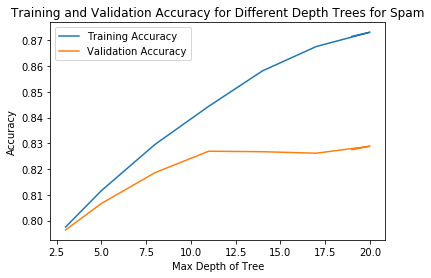

In [216]:
plt.plot(depths, train_acc_avg, label="Training Accuracy")
plt.plot(depths, test_acc_avg, label='Validation Accuracy')
plt.title("Training and Validation Accuracy for Different Depth Trees for Spam")
plt.ylabel('Accuracy')
plt.xlabel('Max Depth of Tree')
plt.legend()

In [218]:
# redoing the kaggle for the spam, since it didn't meet the Kaggle cutoff
# best depth by validation was 11
kag_dt_s_2 = DecisionTree(max_depth=11, feature_labels=features)
kag_dt_s_2.fit(spam_train, spam_labels)
kag_dt_s_pred2 = kag_dt_s_2.predict(spam_test).astype(int)
kag_spam_2 = pd.DataFrame(kag_dt_s_pred2, np.arange(1, len(kag_dt_s_pred2) + 1))
kag_spam_2.reset_index(level=0, inplace=True)
kag_spam_2.to_csv("spam_pred2", header=["Id", "Category"], index=False)

### 3.5.2

In [191]:
# Breadth-First Search of a Decision Tree for Spam
def walk_tree(tree):
    queue = [tree]
    while queue:
        pointer = queue.pop(0)
        if not pointer.left and not pointer.right:
            print("I am a leaf and my prediction is " + str(pointer.pred))
        else:
            print("My split feature is " + str(features[pointer.split_idx]) 
              + " and the threshold is " + str(pointer.thresh))
        if pointer.left:
            queue.append(pointer.left)
        if pointer.right:
            queue.append(pointer.right)
walk_tree(kag_dt_s)

My split feature is exclamation and the threshold is 1e-05
My split feature is meter and the threshold is 1e-05
My split feature is ampersand and the threshold is 1e-05
My split feature is parenthesis and the threshold is 1e-05
I am a leaf and my prediction is 0
My split feature is meter and the threshold is 1e-05
My split feature is money and the threshold is 1e-05
My split feature is pain and the threshold is 1e-05
My split feature is private and the threshold is 1e-05
My split feature is volumes and the threshold is 1e-05
I am a leaf and my prediction is 0
My split feature is dollar and the threshold is 13.888887777777777
My split feature is dollar and the threshold is 1e-05
My split feature is ampersand and the threshold is 1e-05
My split feature is square_bracket and the threshold is 1e-05
My split feature is differ and the threshold is 1e-05
My split feature is ampersand and the threshold is 1e-05
My split feature is money and the threshold is 1e-05
I am a leaf and my prediction 

### 3.5.3

In [261]:
# Reusing my hyperparameter tuning from above
# Cross-validation to select hyperparameters for spam
depths = [1, 3, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 40]

train_acc_3 = []
test_acc_3 = []

for i in depths:
    treetr = DecisionTree(max_depth=i, feature_labels=features)
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
                                        spam_train, spam_labels, test_size=0.20, random_state=90)
    treetr.fit(X_train, y_train)
    train_acc = np.sum(treetr.predict(X_train) == y_train)/len(y_train)
    test_acc = np.sum(treetr.predict(X_test) == y_test)/len(y_test)
    train_acc_3.append(train_acc)
    test_acc_3.append(test_acc)

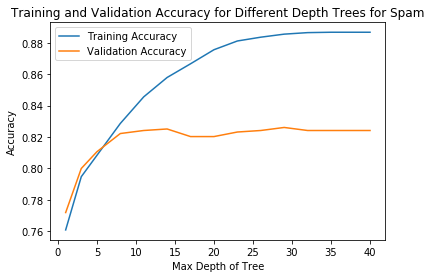

In [263]:
plt.plot(depths, train_acc_3, label="Training Accuracy")
plt.plot(depths, test_acc_3, label='Validation Accuracy')
plt.title("Training and Validation Accuracy for Different Depth Trees for Spam")
plt.ylabel('Accuracy')
plt.xlabel('Max Depth of Tree')
plt.legend()

### 3.6

In [270]:
# Breadth-First Search of Titanic Decision Trees to help me Draw
def walk_titanic(tree):
    queue = [tree]
    while queue:
        pointer = queue.pop(0)
        if not pointer.left and not pointer.right:
            print("I am a leaf and my prediction is " + str(pointer.pred))
        else:
            print("My split feature is " + str(titanic_X.columns[pointer.split_idx]) 
              + " and the threshold is " + str(pointer.thresh))
        if pointer.left:
            queue.append(pointer.left)
        if pointer.right:
            queue.append(pointer.right)
tree3_6 = DecisionTree(max_depth=4, feature_labels=titanic_X.columns)
tree3_6.fit(titanic_X.values, titanic_labels)
walk_titanic(tree3_6)

My split feature is sex_female and the threshold is 1e-05
My split feature is age and the threshold is 9.259296666666668
My split feature is pclass and the threshold is 2.11111
My split feature is sibsp and the threshold is 1.111116666666667
My split feature is pclass and the threshold is 1.00001
My split feature is age and the threshold is 59.31481666666667
My split feature is fare and the threshold is 27.816669999999995
My split feature is pclass and the threshold is 2.11111
I am a leaf and my prediction is 0.0
My split feature is age and the threshold is 56.99999666666666
My split feature is parch and the threshold is 1.0000077777777778
My split feature is embarked_S and the threshold is 1e-05
My split feature is pclass and the threshold is 1.00001
My split feature is age and the threshold is 26.185198888888884
My split feature is age and the threshold is 7.111118888888889
I am a leaf and my prediction is 1.0
I am a leaf and my prediction is 1.0
I am a leaf and my prediction is 0.0
